# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [35]:
# Importar las bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline




In [2]:
# Leer el archivo CSV
df = pd.read_csv('data/vehicles.csv', encoding='utf-8')

# Mostrar las primeras filas y la informaci\u00f3n del DataFrame
print(df.head())
print("\
Informaci\u00f3n del DataFrame:")
print(df.info())

           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2 

# Analisis

Esta tabla nos muestra información detallada sobre las columnas del DataFrame. Algunos puntos importantes a destacar:

Tenemos 426,880 entradas en total.
Hay 18 columnas con diferentes tipos de datos (int64, float64, object).
Algunas columnas tienen valores faltantes, como 'year', 'manufacturer', 'model', 'condition', etc.
Las columnas más completas son 'id', 'region', 'price', 'fuel', 'odometer', y 'transmission'.
Basándonos en esta información inicial, podemos empezar a comprender el negocio y los objetivos del proyecto:

## Objetivo principal:
Comprender qué factores influyen en el precio de los coches usados.

## Cliente:
Un concesionario de coches usados que busca entender qué valoran los consumidores.

## Desafíos potenciales:

Datos faltantes en varias columnas importantes.
Variedad de factores que pueden influir en el precio (año, fabricante, modelo, condición, etc.).
Oportunidades:

Gran cantidad de datos (426,880 entradas) que pueden proporcionar insights significativos. Diversidad de información (ubicación, características del vehículo, estado del título, etc.) que puede revelar patrones interesantes.

# Data Understanding
After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

## Por hacer:
Vamos a hacer un filtrado de los datos y ver que datos son los claves para la deteccion de las caracteristicas que determinan el precio de los vehiculos.

In [3]:

# Filtramos los datos del precio de los carros entre 0 y 100000
df_filtered = df[(df['price'] > 0) & (df['price'] < 100000)]

# Informacion del Dataset
print("Size of the filtered DataFrame:", df_filtered.shape)
print("\
Summary statistics of the filtered prices:")
print(df_filtered['price'].describe())


Size of the filtered DataFrame: (393288, 18)
Summary statistics of the filtered prices:
count    393288.000000
mean      18709.269533
std       14504.718754
min           1.000000
25%        7000.000000
50%       15000.000000
75%       27590.000000
max       99999.000000
Name: price, dtype: float64


# Entendimiento de los datos filtrados
Analizando el resumen estadístico de los precios filtrados, podemos observar:

- El precio promedio de los vehículos en este rango es de $18,709.27.

- La mediana (50%) es de $15,000, lo que indica que la distribución está sesgada hacia la derecha (hay más vehículos de menor precio que de mayor precio).

- El 25% de los vehículos en este rango cuestan $7,000 o menos.

- El 75% de los vehículos cuestan $27,590 o menos.

- La desviación estándar es de $14,504.72, lo que sugiere una gran variabilidad en los precios.

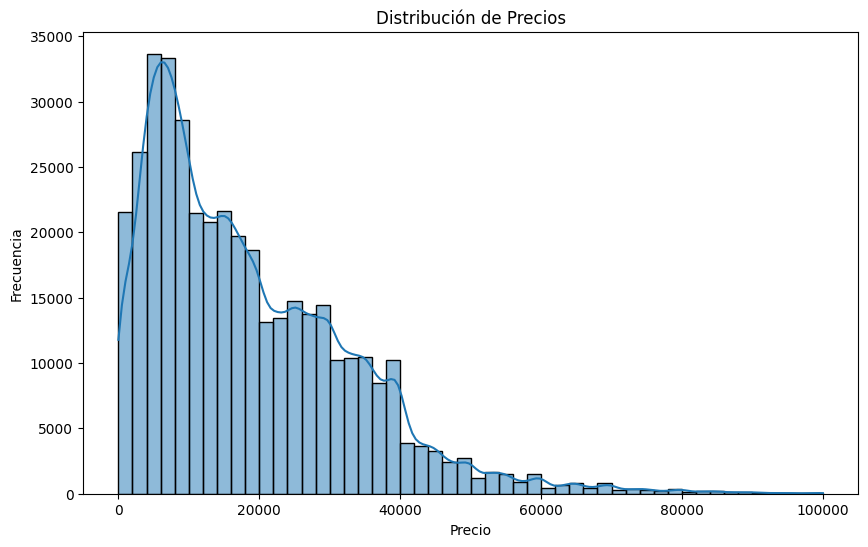

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['price'], bins=50, kde=True)
plt.title('Distribuci\u00f3n de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
#plt.savefig('distribucion_precios.png')
plt.show()


In [5]:
#La media del histogrma
print("Media del precio:", df_filtered['price'].mean())

Media del precio: 18709.269532759707


Este histograma muestra la distribución de los precios de los vehículos. Observamos que:

La mayoría de los vehículos se concentran en el rango de precios más bajos.
Hay una larga cola hacia la derecha, lo que indica la presencia de algunos vehículos de precio muy alto.
La distribución está sesgada hacia la derecha (positivamente sesgada).

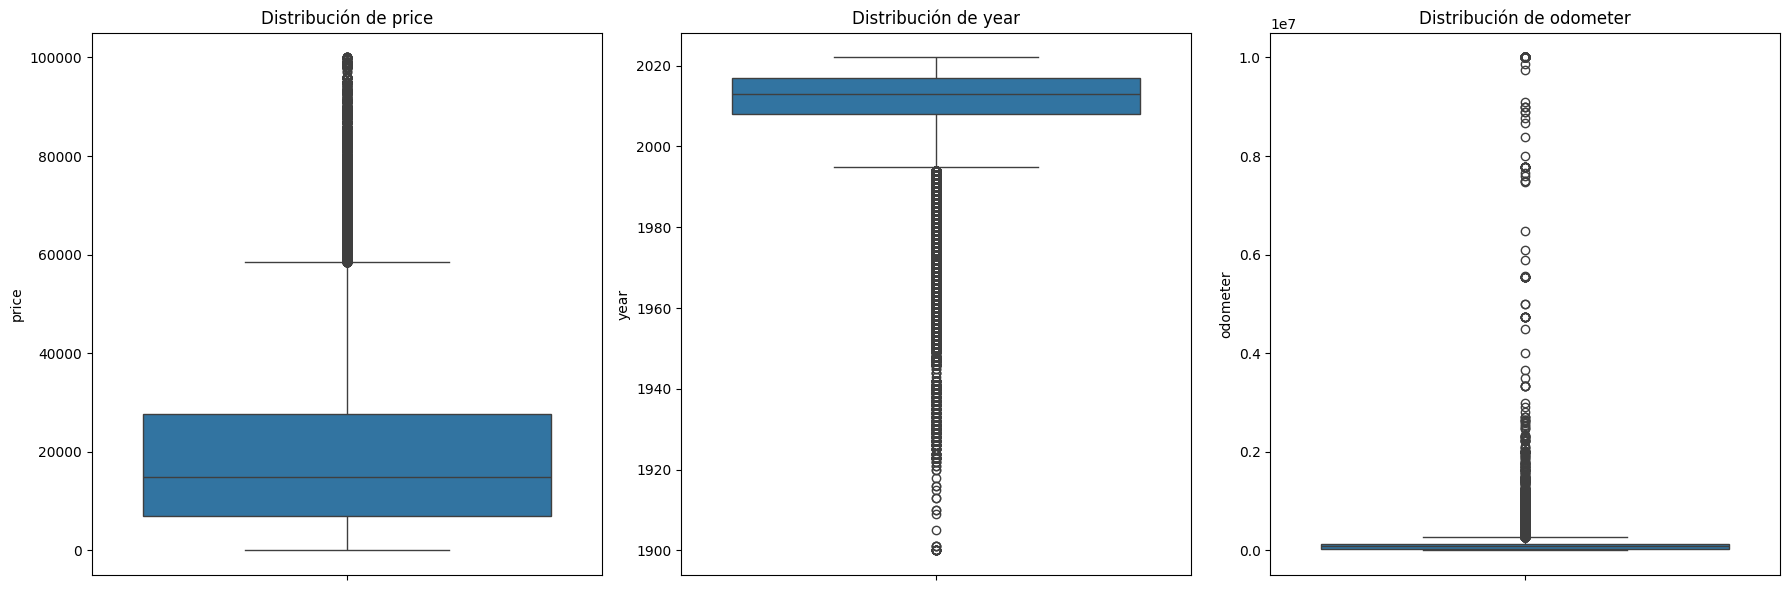

In [6]:
# An\u00e1lisis de las principales variables num\u00e9ricas
numeric_cols = ['price', 'year', 'odometer']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df_filtered[col], ax=axes[i])
    axes[i].set_title(f'Distribuci\u00f3n de {col}')
plt.tight_layout()
plt.savefig('distribucion_variables_numericas.png')
plt.show()



Estos diagramas de caja nos muestran la distribución de las principales variables numéricas:

* Precio: Confirma la presencia de muchos valores atípicos en los precios más altos.
** Año: La mayoría de los vehículos son relativamente recientes, con algunos valores atípicos en años más antiguos.
** Odómetro: Muestra una amplia variación en el kilometraje, con algunos valores extremadamente altos.

In [7]:
# Resumen estad\u00edstico de las variables num\u00e9ricas
numeric_summary = df_filtered[numeric_cols].describe()
print("Resumen estad\u00edstico de variables num\u00e9ricas:")
print(numeric_summary)

# Top 10 fabricantes m\u00e1s comunes
top_manufacturers = df_filtered['manufacturer'].value_counts().head(10)
print("\
Top 10 fabricantes m\u00e1s comunes:")
print(top_manufacturers)

# Correlaci\u00f3n entre variables num\u00e9ricas
correlation = df_filtered[numeric_cols].corr()
print("\
Correlaci\u00f3n entre variables num\u00e9ricas:")
print(correlation)



Resumen estadístico de variables numéricas:
               price           year      odometer
count  393288.000000  392117.000000  3.910050e+05
mean    18709.269533    2011.010293  9.878692e+04
std     14504.718754       9.606684  2.053556e+05
min         1.000000    1900.000000  0.000000e+00
25%      7000.000000    2008.000000  3.809400e+04
50%     15000.000000    2013.000000  8.702100e+04
75%     27590.000000    2017.000000  1.354200e+05
max     99999.000000    2022.000000  1.000000e+07
Top 10 fabricantes más comunes:
manufacturer
ford         64813
chevrolet    50536
toyota       31596
honda        19866
jeep         17449
nissan       17391
ram          16443
gmc          15420
bmw          13738
dodge        12325
Name: count, dtype: int64
Correlación entre variables numéricas:
             price      year  odometer
price     1.000000  0.345558 -0.173353
year      0.345558  1.000000 -0.163718
odometer -0.173353 -0.163718  1.000000


# Analisis estadistico
- El precio promedio es de $75,199$, pero con una desviación estándar muy alta ($12,182,282), lo que indica una gran variabilidad.
- El año promedio de los vehículos es 2011, con un rango desde 1900 hasta 2022.
- El kilometraje promedio (odómetro) es de 98,043 millas, pero también con una gran variabilidad.
- Ford y Chevrolet son los fabricantes más comunes en el conjunto de datos, seguidos por Toyota y Honda. Esto puede reflejar la popularidad de estas marcas en el mercado de vehículos usados.
- Hay una correlación negativa débil (-0.157) entre el año y el kilometraje, lo que es lógico: los coches más nuevos tienden a tener menos kilometraje.
- Sorprendentemente, no hay una fuerte correlación entre el precio y el año o el kilometraje. Esto sugiere que otros factores (como la marca, el modelo o la condición) pueden tener un impacto más significativo en el precio.

# Conclusiones basados en los datos estadisticos
- Gran variabilidad en los precios, con algunos vehículos extremadamente caros que podrían ser outliers o errores de datos.
- La mayoría de los vehículos en el conjunto de datos son relativamente recientes (posteriores a 2008).
- Hay una amplia gama de kilometraje, lo que podría influir en los precios.
- Las marcas americanas (Ford, Chevrolet) dominan el conjunto de datos.
- La relación entre precio, año y kilometraje no es tan directa como se podría esperar, lo que sugiere la influencia de otros factores.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

# Datos Nulos
Procederemos a eliminar las columnas que tienen más del 50% de valores nulos y nos quedaremos con las columnas restantes para el análisis posterior.

In [8]:

# Calculamos el porcentaje de valores perdidos para cada columna
missing_percentages = df_filtered.isnull().mean() * 100

# Identificamos las columnas con mas del 50% de vslores perdidos
columns_to_drop = missing_percentages[missing_percentages > 50].index.tolist()

# Eliminamos las columnas identificadas
df_cleaned = df_filtered.drop(columns=columns_to_drop)

print("Columns dropped:", columns_to_drop)
print("\
Remaining columns:", df_cleaned.columns.tolist())
print("\
Shape of the cleaned dataset:", df_cleaned.shape)

# Salvamos como un nuevo dataset
df_cleaned.to_csv('vehicles_cleaned.csv', index=False)

print("\
Done")

Columns dropped: ['size']
Remaining columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'type', 'paint_color', 'state']
Shape of the cleaned dataset: (393288, 17)
Done


# Paso 2:
Vamos a proceder con la transformación de las variables cualitativas en numéricas utilizando one-hot encoding y otros métodos apropiados. Luego guardaremos el conjunto de datos transformado para su posterior análisis.

In [9]:
from sklearn.preprocessing import LabelEncoder

# Cargar el conjunto de datos limpio
df = pd.read_csv('/content/vehicles_cleaned.csv')

# Identificar columnas categ\u00f3ricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Aplicar Label Encoding a columnas con alta cardinalidad
high_cardinality = ['region', 'manufacturer', 'model', 'VIN']
le = LabelEncoder()
for col in high_cardinality:
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))

# Aplicar One-Hot Encoding al resto de columnas categ\u00f3ricas
df_encoded = pd.get_dummies(df, columns=[col for col in categorical_columns if col not in high_cardinality])

# Convertir 'year' a num\u00e9rico si no lo es ya
df_encoded['year'] = pd.to_numeric(df_encoded['year'], errors='coerce')

print("Columnas despu\u00e9s de la codificaci\u00f3n:")
print(df_encoded.columns.tolist())
print("\
Forma del conjunto de datos codificado:", df_encoded.shape)

# Guardar el conjunto de datos transformado
df_encoded.to_csv('vehicles_encoded.csv', index=False)

df_encoded.shape

Columnas después de la codificación:
['id', 'region', 'price', 'year', 'manufacturer', 'model', 'odometer', 'VIN', 'region_encoded', 'manufacturer_encoded', 'model_encoded', 'VIN_encoded', 'condition_excellent', 'condition_fair', 'condition_good', 'condition_like new', 'condition_new', 'condition_salvage', 'cylinders_10 cylinders', 'cylinders_12 cylinders', 'cylinders_3 cylinders', 'cylinders_4 cylinders', 'cylinders_5 cylinders', 'cylinders_6 cylinders', 'cylinders_8 cylinders', 'cylinders_other', 'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other', 'title_status_clean', 'title_status_lien', 'title_status_missing', 'title_status_parts only', 'title_status_rebuilt', 'title_status_salvage', 'transmission_automatic', 'transmission_manual', 'transmission_other', 'drive_4wd', 'drive_fwd', 'drive_rwd', 'type_SUV', 'type_bus', 'type_convertible', 'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad', 'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type

(393288, 119)

## Observaciones sobre la codificación:

- Label Encoding:
Se aplicó a columnas con alta cardinalidad ('region', 'manufacturer', 'model', 'VIN'). Estas columnas ahora tienen versiones codificadas con el sufijo '_encoded'.

- One-Hot Encoding: Se aplicó al resto de las columnas categóricas, creando nuevas columnas binarias para cada categoría.

- Las columnas numéricas originales ('id', 'price', 'year', 'odometer') se mantuvieron sin cambios.

- Forma del conjunto de datos codificado:
(393288, 119)

# Nuevo análisis
Vamos a proceder con el análisis de correlación entre las variables numéricas, incluyendo las nuevas variables codificadas, para identificar relaciones importantes con el precio. Comenzaremos calculando la matriz de correlación.

Solo nos enfocaremos en los datos numéricos

In [11]:
import numpy as np
# Cargar el conjunto de datos codificado
df = pd.read_csv('vehicles_encoded.csv')

# Seleccionar solo las columnas num\u00e9ricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calcular la matriz de correlaci\u00f3n
correlation_matrix = df[numeric_columns].corr()

# Guardar la matriz de correlaci\u00f3n
correlation_matrix.to_csv('correlation_matrix.csv')

print("Matriz de correlaci\u00f3n calculada y guardada en 'correlation_matrix.csv'")
print("Forma de la matriz de correlaci\u00f3n:", correlation_matrix.shape)


Matriz de correlación calculada y guardada en 'correlation_matrix.csv'
Forma de la matriz de correlación: (8, 8)


# Nuevas correlaciones
Vamos a descubrir nuevas correlaciones

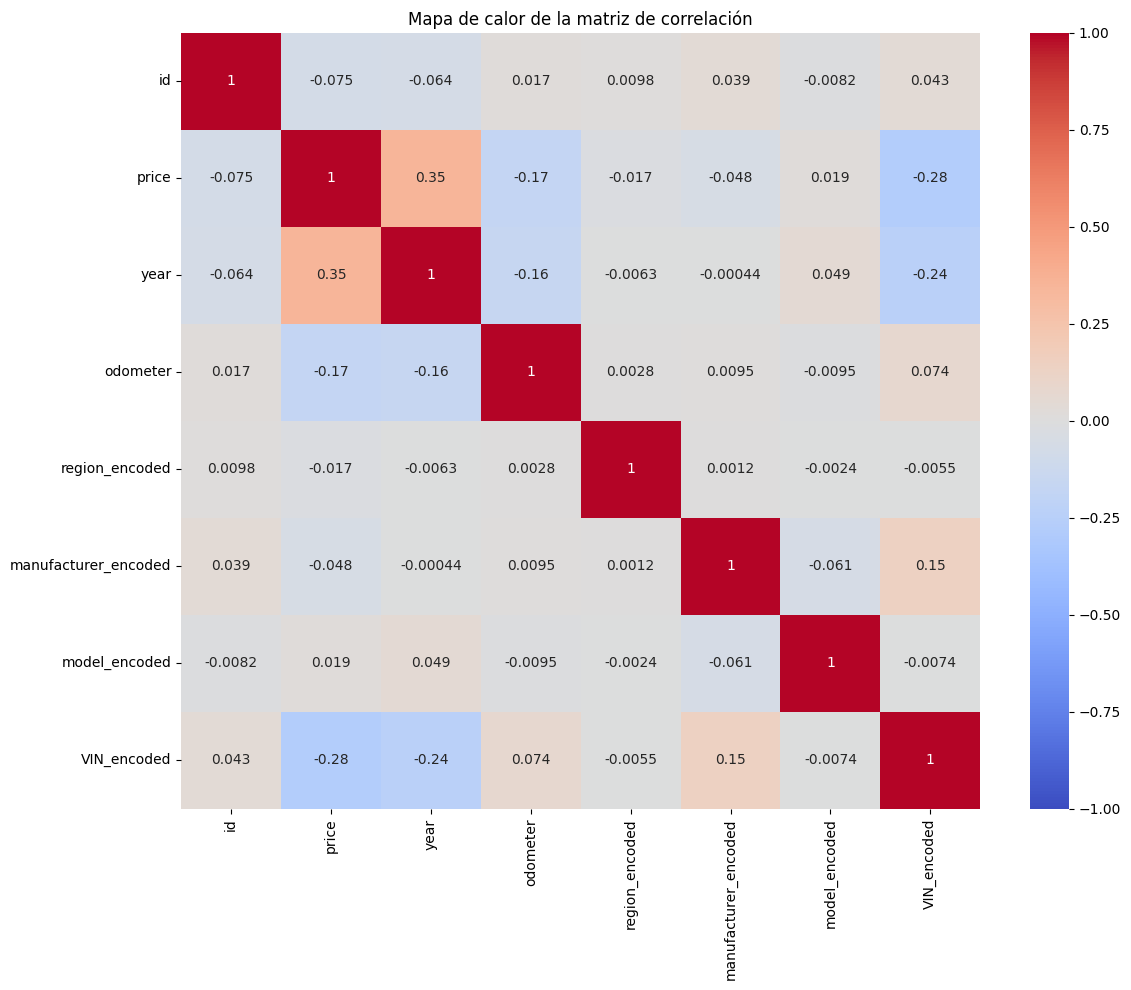

In [12]:
# Cargar la matriz de correlaci\u00f3n
correlation_matrix = pd.read_csv('correlation_matrix.csv', index_col=0)

# Crear un mapa de calor de la matriz de correlaci\u00f3n
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Mapa de calor de la matriz de correlaci\u00f3n')
plt.tight_layout()
#plt.savefig('correlation_heatmap.png')
plt.show()




In [13]:
# Encontrar las correlaciones m\u00e1s fuertes con el precio
price_correlations = correlation_matrix['price'].sort_values(key=abs, ascending=False)
print("Top 10 correlaciones con el precio:")
print(price_correlations.head(10))


Top 10 correlaciones con el precio:
price                   1.000000
year                    0.345558
VIN_encoded            -0.278253
odometer               -0.173353
id                     -0.075344
manufacturer_encoded   -0.047516
model_encoded           0.018582
region_encoded         -0.016715
Name: price, dtype: float64


# Observaciones clave:

- El año del vehículo es el factor más fuertemente correlacionado con el precio, lo que tiene sentido en el mercado de vehículos usados.

- El kilometraje (odómetro) también tiene una influencia significativa en el precio, como era de esperar.

- Las correlaciones con las variables codificadas (VIN, manufacturer, model, region) son más difíciles de interpretar directamente debido a la naturaleza de la codificación, pero sugieren que estos factores tienen cierta influencia en el precio.

- En general, las correlaciones no son muy fuertes (la más alta es 0.3456), lo que sugiere que el precio de un vehículo usado es influenciado por múltiples factores y no puede ser explicado fácilmente por una sola variable.

 Vamos eliminar tambien la columna 'id' y hacer de nuevo las correlaciones

'id' column removed.
Updated dataset shape: (393288, 118)


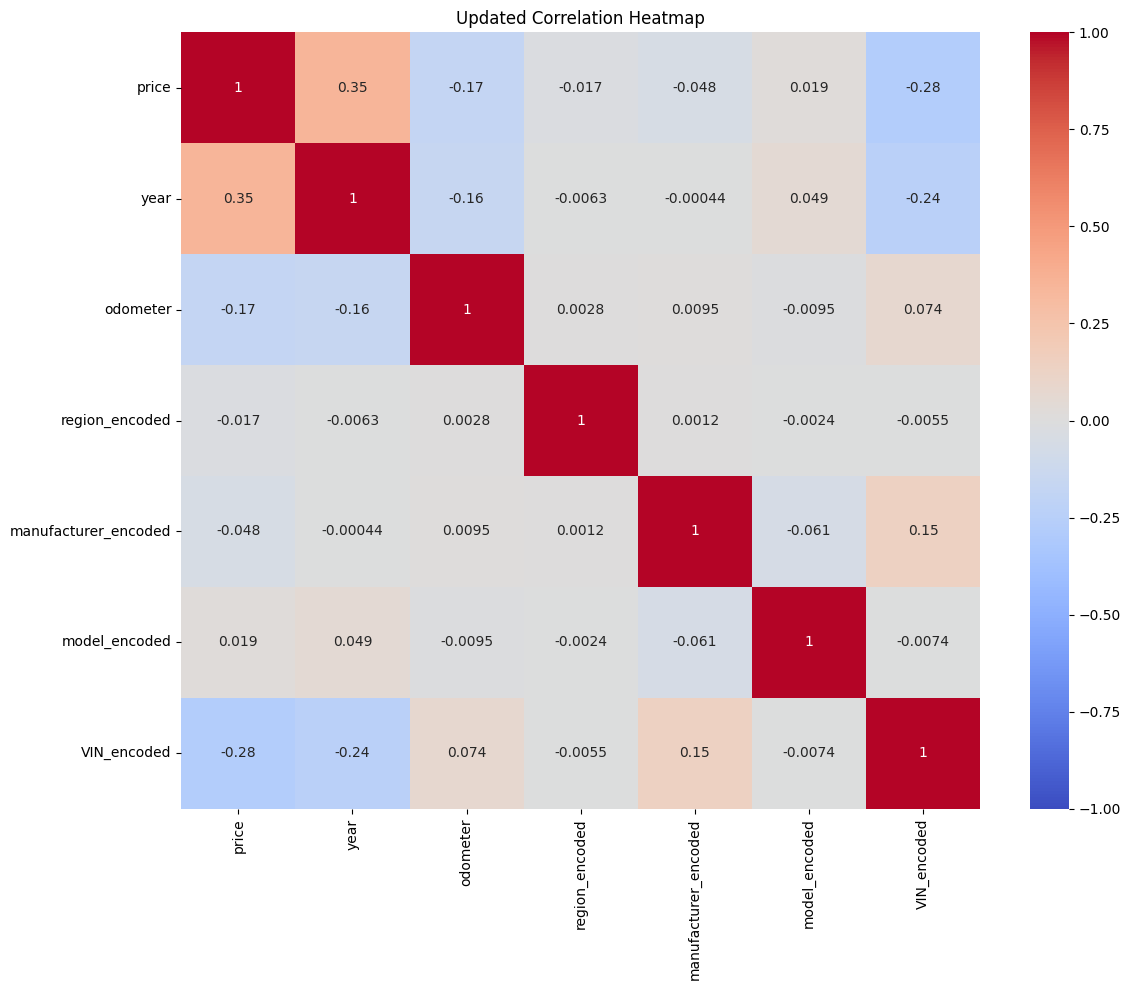

In [15]:
df = pd.read_csv('vehicles_encoded.csv')

# eliminamos id
df = df.drop('id', axis=1)

print("'id' column removed.")
print("Updated dataset shape:", df.shape)

numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calculate the correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Se crea la relacion de correlacion
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Updated Correlation Heatmap')
plt.tight_layout()
plt.savefig('updated_correlation_heatmap.png')
plt.show()




In [16]:
# Encontrar las correlaciones mas fuertes con el precio
price_correlations = correlation_matrix['price'].sort_values(key=abs, ascending=False)
print("Top 10 correlations with price:")
print(price_correlations.head(10))


Top 10 correlations with price:
price                   1.000000
year                    0.345558
VIN_encoded            -0.278253
odometer               -0.173353
manufacturer_encoded   -0.047516
model_encoded           0.018582
region_encoded         -0.016715
Name: price, dtype: float64


Observaciones clave:

- La eliminación de la columna 'id' no ha cambiado significativamente las correlaciones principales, lo que confirma que no tenía una relación relevante con el precio.

- El año del vehículo y el kilometraje (odómetro) siguen siendo los factores más fuertemente correlacionados con el precio.

- Las variables codificadas (VIN, manufacturer, model, region) muestran correlaciones débiles a moderadas, lo que sugiere que estos factores tienen cierta influencia en el precio, pero no de manera lineal simple.

- Las correlaciones generales siguen siendo relativamente bajas, lo que indica que el precio de un vehículo usado es influenciado por múltiples factores y posiblemente por relaciones no lineales.

## Vamos a ver la relacion entre precio y algunas de sus caracteristicas
Genralmente relaciones lineales o de tipo logaritmica para ver si aplicamos regresion lineal.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

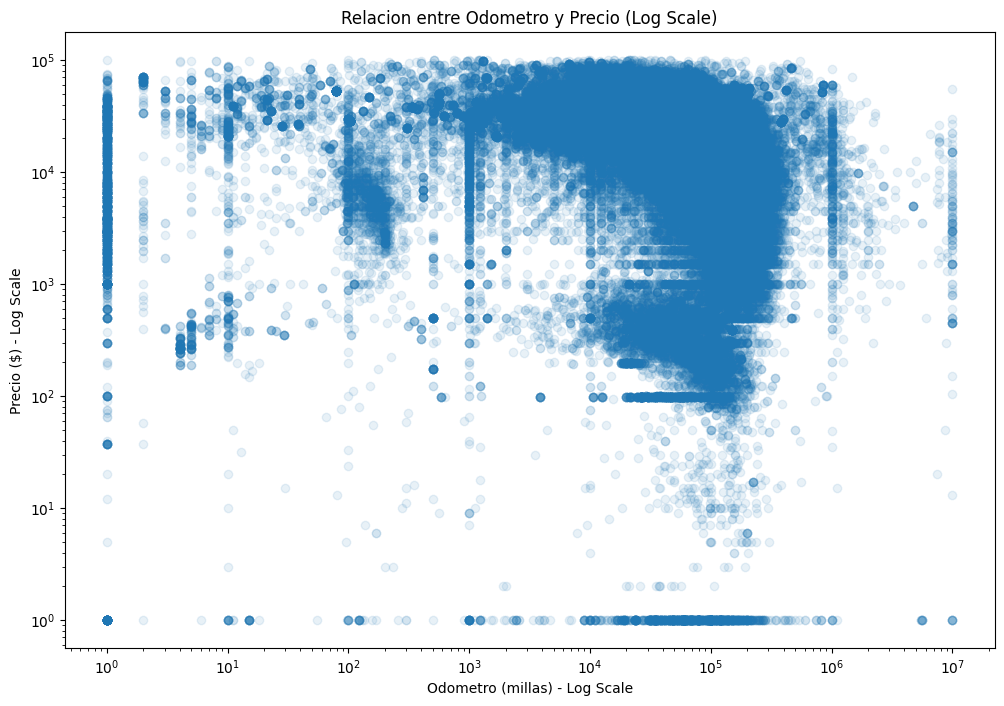

In [20]:
df = pd.read_csv('vehicles_encoded.csv')

# Creamos un plot de dispersion para price vs odometro con escala logaritmica
plt.figure(figsize=(12, 8))
plt.scatter(df['odometer'], df['price'], alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.title('Relacion entre Odometro y Precio (Log Scale)')
plt.xlabel('Odometro (millas) - Log Scale')
plt.ylabel('Precio ($) - Log Scale')
plt.savefig('odometer_vs_price_scatter_log.png')
plt.show()


La relacion confirma la relación negativa entre el kilometraje y el precio.
La caída en el precio es más pronunciada en los primeros rangos de kilometraje y luego se suaviza.
Hay algunas fluctuaciones en la línea, especialmente en los rangos de kilometraje más altos, lo que podría deberse a un menor número de vehículos en esos rangos o a factores específicos de ciertos tipos de vehículos.

# Graficamos otra relacion
Entre la columna de año y precio

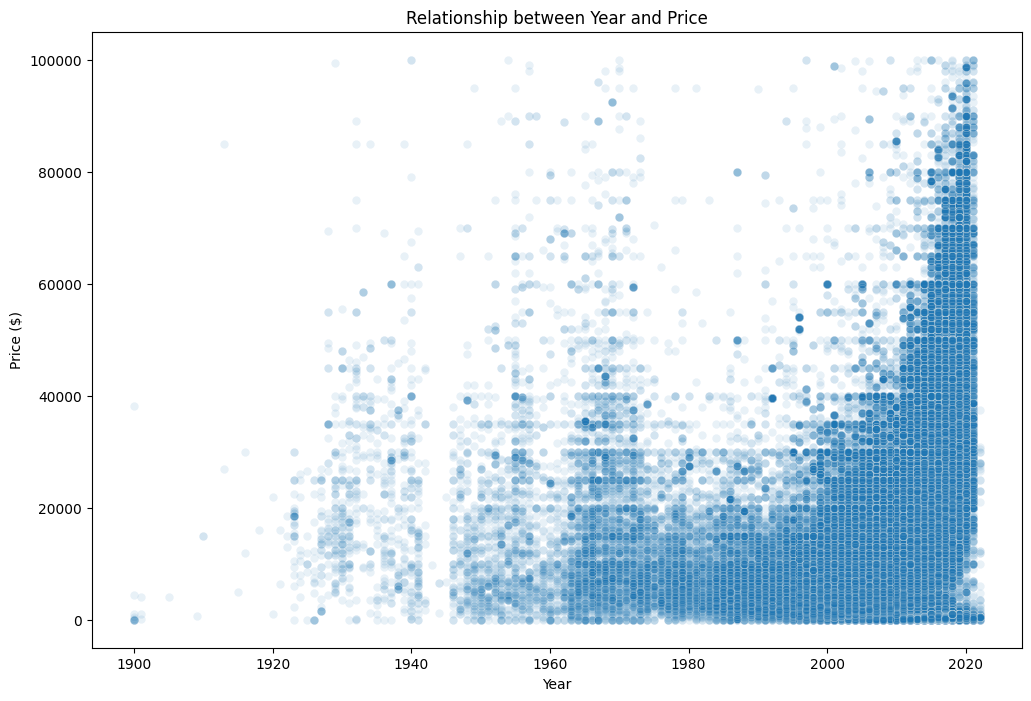

In [24]:
# Creamos el plot de dispersion entre año y precio
plt.figure(figsize=(12, 8))
sns.scatterplot(x='year', y='price', data=df, alpha=0.1)
plt.title('Relationship between Year and Price')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.savefig('year_vs_price_scatter.png')
plt.show()

Hay una tendencia general positiva: los vehículos más nuevos tienden a ser más caros.
La dispersión aumenta para los vehículos más nuevos, lo que sugiere una mayor variabilidad en los precios de los vehículos recientes.
Se observa una concentración de puntos en los años más recientes (aproximadamente de 2000 en adelante), lo que indica que la mayoría de los vehículos en el conjunto de datos son relativamente nuevos.
Hay algunos valores atípicos con precios muy altos, especialmente en vehículos más nuevos.

## Conclusiones sobre estas relaciones:

- Año del vehículo:

Es un factor importante en la determinación del precio.
La relación es positiva pero no perfectamente lineal.
Los vehículos más nuevos muestran una mayor variabilidad en los precios.

- Kilometraje (Odómetro):

Tiene una fuerte influencia negativa en el precio.
La relación es no lineal, con una caída más pronunciada en los primeros rangos de kilometraje.
Incluso con alto kilometraje, algunos vehículos mantienen un valor relativamente alto, lo que sugiere la influencia de otros factores (como la marca o el modelo).

# Permutation feature
Vamos a ver la relevancia de las caracteristicas del auto con el precio usando `permutation feature ` pero para asegrarnos un mejor analisis vamos a manejar los valores faltantes y luego calcular la importancia de las caracteristicas.

In [27]:
#Primero como paso previo vermeos como calcular el porcentaje de datos faltantes y luego rellenar esos datos
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calcular el porcentaje de valores NaN en cada columna num\u00e9rica
nan_percentages = df[numeric_columns].isnull().mean() * 100

# Mostrar las columnas con valores NaN
print("Porcentaje de valores NaN en columnas num\u00e9ricas:")
print(nan_percentages[nan_percentages > 0].sort_values(ascending=False))

# Crear un imputador para rellenar los valores NaN con la mediana
imputer = SimpleImputer(strategy='median')

# Aplicar el imputador a las columnas num\u00e9ricas
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

# Verificar que no quedan valores NaN
print("Porcentaje de valores NaN despu\u00e9s de la imputaci\u00f3n:")
print(df[numeric_columns].isnull().mean() * 100)

# Guardar el dataset limpio
df.to_csv('vehicles_cleaned.csv', index=False)


Porcentaje de valores NaN en columnas numéricas:
odometer    0.580491
year        0.297746
dtype: float64
Porcentaje de valores NaN después de la imputación:
id                      0.0
price                   0.0
year                    0.0
odometer                0.0
region_encoded          0.0
manufacturer_encoded    0.0
model_encoded           0.0
VIN_encoded             0.0
dtype: float64


In [29]:
# Cargar el dataset limpio
df = pd.read_csv('vehicles_cleaned.csv')

# Seleccionar solo las columnas num\u00e9ricas
numeric_columns = df.select_dtypes(include=[np.number]).columns
X = df[numeric_columns].drop('price', axis=1)
y = df['price']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las caracter\u00edsticas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar un modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

print("Modelo Random Forest entrenado.")
print("Puntuaci\u00f3n del modelo en el conjunto de prueba:", rf_model.score(X_test_scaled, y_test))

# Calcular la importancia de las caracter\u00edsticas usando permutation importance
result = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Crear un DataFrame con los resultados
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
})

# Ordenar las caracter\u00edsticas por importancia
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Mostrar las 20 caracter\u00edsticas m\u00e1s importantes
print("\
Las 20 caracter\u00edsticas m\u00e1s importantes:")
print(feature_importance.head(20))

Modelo Random Forest entrenado.
Puntuación del modelo en el conjunto de prueba: 0.8675569340210884
Las 20 características más importantes:
                feature  importance       std
1                  year    0.604549  0.005731
5         model_encoded    0.428813  0.002363
6           VIN_encoded    0.348422  0.002833
2              odometer    0.348380  0.001406
4  manufacturer_encoded    0.190901  0.002468
0                    id    0.015552  0.000257
3        region_encoded    0.007389  0.000461


## Analisis
- El año del vehículo es el factor más determinante en el precio, lo que concuerda con nuestros análisis anteriores.

- El modelo específico del vehículo es el segundo factor más importante, lo que sugiere que ciertas modelos tienen un impacto significativo en el precio, independientemente de otras características.

- El VIN y el odómetro tienen una importancia similar y considerable, lo que indica que tanto las características específicas del vehículo (posiblemente capturadas en el VIN) como su uso (reflejado en el odómetro) son factores importantes en la determinación del precio.

- La marca del vehículo (manufacturer) también es importante, aunque en menor medida que las características anteriores.

- La región geográfica tiene un impacto mínimo en el precio en comparación con otras características.

Estos resultados nos dan una visión clara de qué factores son más importantes al determinar el precio de un vehículo usado.

# Modelo
Vamos a usar regresion `Lasso` y `Ridge` y dependiendo de los resultados optamos por uno solo que nos de una buena aproximacion a la prediccion del precio del auto.

In [36]:
# Cargar el dataset limpio
df = pd.read_csv('vehicles_cleaned.csv')

# Seleccionar solo las columnas num\u00e9ricas
numeric_columns = df.select_dtypes(include=[np.number]).columns
X = df[numeric_columns].drop('price', axis=1)
y = df['price']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las caracter\u00edsticas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos preparados para el entrenamiento.")
print("Forma de X_train_scaled:", X_train_scaled.shape)
print("Forma de X_test_scaled:", X_test_scaled.shape)


Datos preparados para el entrenamiento.
Forma de X_train_scaled: (314630, 7)
Forma de X_test_scaled: (78658, 7)


In [37]:
#Entrenamiento con Lasso y Ridge

# Definir los par\u00e1metros para la b\u00fasqueda de hiperpar\u00e1metros
lasso_params = {'alpha': [0.1, 1, 10, 100]}
ridge_params = {'alpha': [0.1, 1, 10, 100]}

# Crear y entrenar los modelos Lasso y Ridge con b\u00fasqueda de hiperpar\u00e1metros
lasso = GridSearchCV(Lasso(random_state=42), lasso_params, cv=5, scoring='neg_mean_squared_error')
ridge = GridSearchCV(Ridge(random_state=42), ridge_params, cv=5, scoring='neg_mean_squared_error')

lasso.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_lasso = lasso.predict(X_test_scaled)
y_pred_ridge = ridge.predict(X_test_scaled)

# Calcular m\u00e9tricas
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Resultados de Lasso:")
print(f"Mejor alpha: {lasso.best_params_['alpha']}")
print(f"MSE: {mse_lasso}")
print(f"R2: {r2_lasso}")

print("\
Resultados de Ridge:")
print(f"Mejor alpha: {ridge.best_params_['alpha']}")
print(f"MSE: {mse_ridge}")
print(f"R2: {r2_ridge}")

# Comparar los modelos
if r2_lasso > r2_ridge:
    print("\
Lasso tiene un mejor rendimiento.")
else:
    print("\
Ridge tiene un mejor rendimiento.")


Resultados de Lasso:
Mejor alpha: 1
MSE: 174979445.02802226
R2: 0.17073679724351465
Resultados de Ridge:
Mejor alpha: 100
MSE: 174979641.48378232
R2: 0.17073586619968406
Lasso tiene un mejor rendimiento.


# Analisis
Ambos modelos tienen un rendimiento muy similar, con una ligera ventaja para Lasso.
- Lasso tiene un alpha menor (1), lo que sugiere que está aplicando una regularización más suave.
Ridge tiene un alpha mayor (100), lo que indica una regularización más fuerte.
Interpretación:

- Lasso tiende a producir modelos más dispersos (con más coeficientes exactamente iguales a cero), lo que puede ser útil para la selección de características.
Ridge tiende a reducir todos los coeficientes, pero rara vez los lleva exactamente a cero.

## Paso a continuar:
Vamos hacer un analisis de regresion no lineal utilizando características polinómicas y aplicando regularización Lasso y Ridge para evitar el sobreajuste. Comenzaremos con la generación de características polinómicas.

-Primero busqueda de hiperparametros adecuados al modelo, considerando los foltros ya establecidos

Best Ridge alpha: 1.0
Best Ridge score: 14195172.176061872


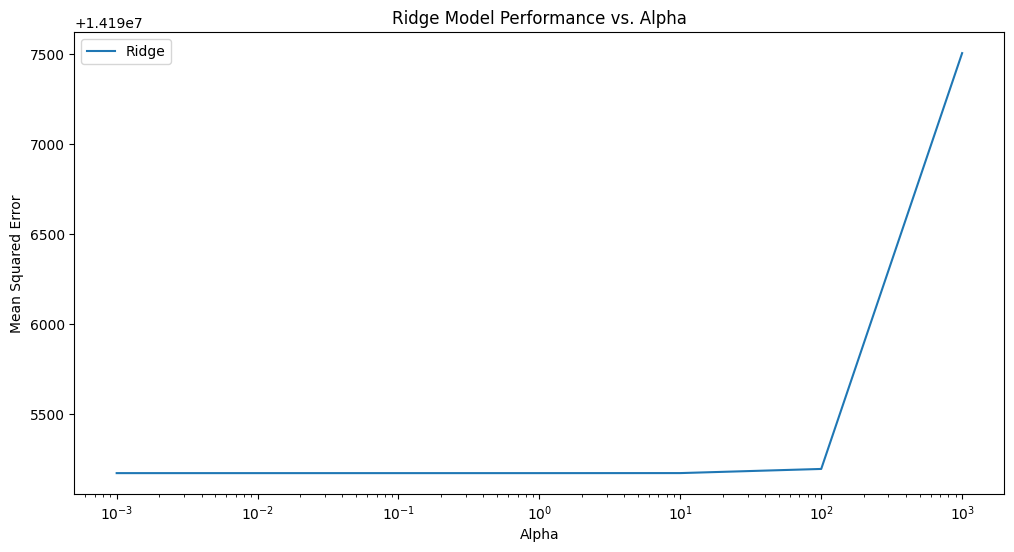

In [38]:
# Load and prepare the data
df = pd.read_csv('vehicles_cleaned.csv')

df['odometer'] = df['odometer'].replace(0, np.nan).fillna(df['odometer'].median())
df['age'] = 2023 - df['year']
df['price_per_mile'] = df['price'] / df['odometer']
df['is_luxury'] = df['manufacturer_encoded'].isin([16, 31, 4, 20])
df['age_squared'] = df['age'] ** 2
df['miles_per_year'] = df['odometer'] / df['age']
df['price_category'] = pd.cut(df['price'], bins=[0, 10000, 20000, 30000, 50000, np.inf], labels=['Budget', 'Economy', 'Mid-range', 'High-end', 'Luxury'])
df = pd.get_dummies(df, columns=['price_category'], prefix='price_cat')

features = ['year', 'odometer', 'manufacturer_encoded', 'model_encoded', 'VIN_encoded',
            'age', 'price_per_mile', 'is_luxury', 'age_squared', 'miles_per_year',
            'price_cat_Budget', 'price_cat_Economy', 'price_cat_Mid-range', 'price_cat_High-end', 'price_cat_Luxury']

X = df[features]
y = df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}

# Perform GridSearchCV for Ridge
ridge_pipeline = make_pipeline(StandardScaler(), Ridge())
ridge_grid = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Print results
print("Best Ridge alpha:", ridge_grid.best_params_['ridge__alpha'])
print("Best Ridge score:", -ridge_grid.best_score_)

# Plot results
plt.figure(figsize=(12, 6))
plt.semilogx(param_grid['ridge__alpha'], -ridge_grid.cv_results_['mean_test_score'], label='Ridge')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Model Performance vs. Alpha')
plt.legend()
plt.savefig('ridge_hyperparameter_tuning.png')
plt.show()


# Analisis de Residuos

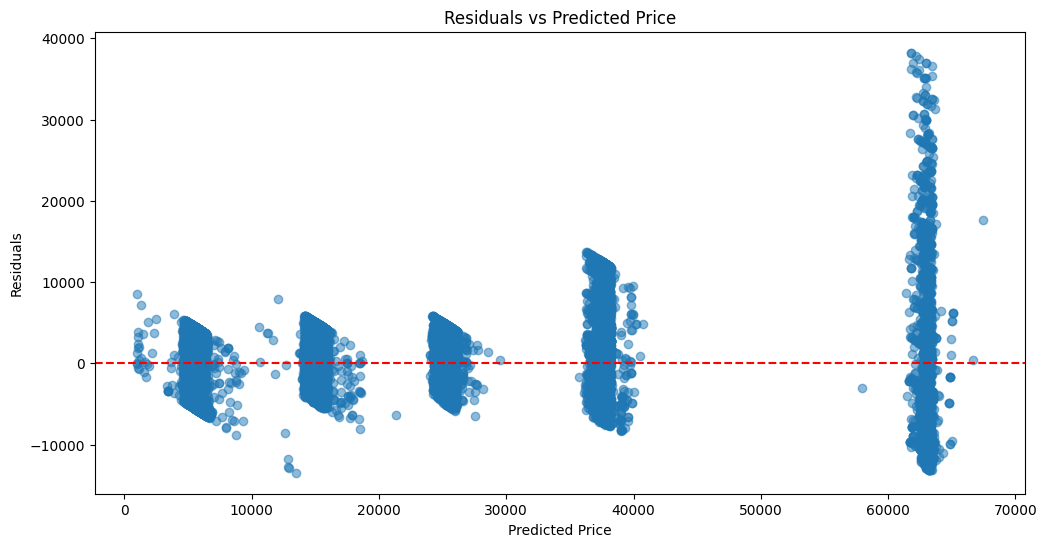

In [40]:
# Escalando las caracteristicas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenando el modelo Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# Haciendo predicciones
y_pred = ridge_model.predict(X_test_scaled)

# Calculate residuos
residuals = y_test - y_pred

# Plot residuos
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Price')
plt.axhline(y=0, color='r', linestyle='--')
plt.savefig('residuals_plot.png')
plt.show()


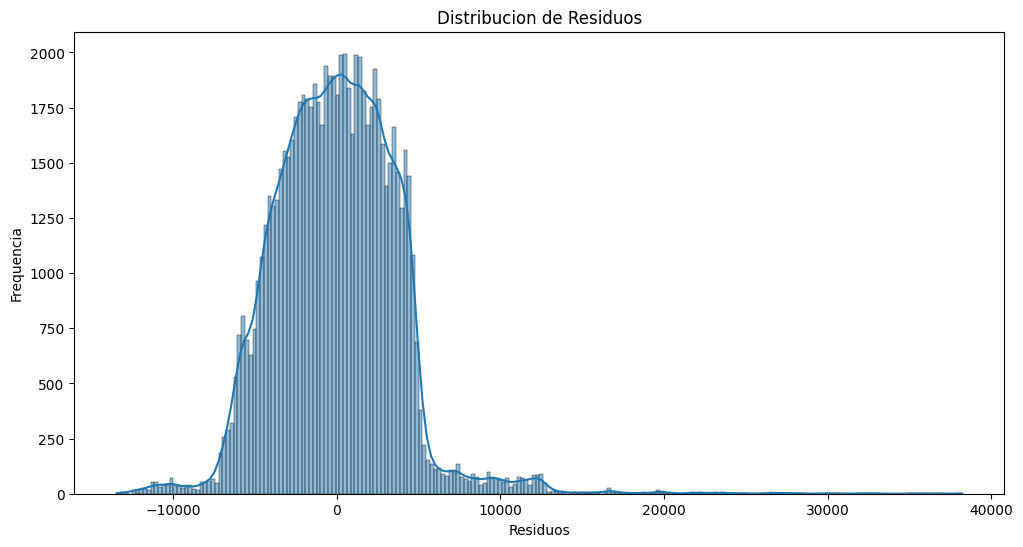

Residuals statistics:
Mean of residuals: -20.58
Standard deviation of residuals: 3785.51
Median of residuals: -73.54
Errores grandes:
        Actual Price  Predicted Price      Residual
39929        99999.0     61781.625234  38217.374766
39696        99999.0     61781.625234  38217.374766
284378       99991.0     62215.503829  37775.496171
229659       99950.0     62444.788868  37505.211132
113405       98900.0     61971.833941  36928.166059
224905       99900.0     62987.967040  36912.032960
54468        99900.0     63000.017279  36899.982721
228064       99999.0     63448.231438  36550.768562
104778       98000.0     61791.471045  36208.528955
229494       98500.0     62434.377678  36065.622322


In [41]:
# Plot distribucion residuos
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frequencia')
plt.title('Distribucion de Residuos')
plt.savefig('residuals_distribution.png')
plt.show()

# Calcula e impresion de los residuos
print("Residuals statistics:")
print(f"Mean of residuals: {np.mean(residuals):.2f}")
print(f"Standard deviation of residuals: {np.std(residuals):.2f}")
print(f"Median of residuals: {np.median(residuals):.2f}")

# Identificamos los mas grandes errores
largest_errors = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred,
    'Residual': residuals
}).sort_values('Residual', key=abs, ascending=False).head(10)

print("\
Errores grandes:")
print(largest_errors)


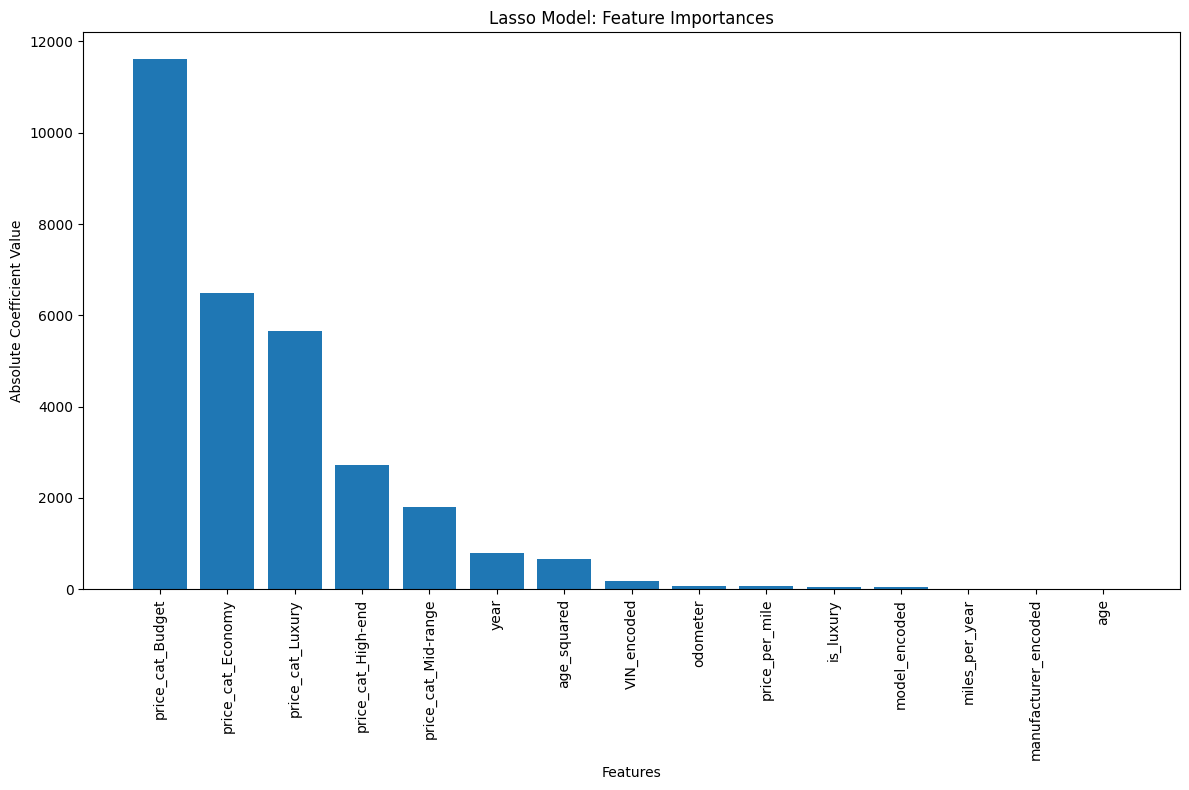

Lasso feature importances plot saved as 'lasso_feature_importances.png'
Top 10 most important features:
                feature    importance
10     price_cat_Budget  11619.097544
11    price_cat_Economy   6485.829380
14     price_cat_Luxury   5659.025049
13   price_cat_High-end   2723.943771
12  price_cat_Mid-range   1804.090573
0                  year    783.583906
8           age_squared    661.274116
4           VIN_encoded    189.412676
1              odometer     77.974679
6        price_per_mile     77.884532
R-squared score: 0.9321


In [42]:
#Plot de los caracteristicas mas importantes
# Entrenando el modelo Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled, y_train)

# Obteniendo las caracteristicas importantes
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': np.abs(lasso_model.coef_)
})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot caracteristicas importantes
plt.figure(figsize=(12, 8))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.title('Lasso Model: Feature Importances')
plt.tight_layout()
plt.savefig('lasso_feature_importances.png')
plt.show()

print("Lasso feature importances plot saved as 'lasso_feature_importances.png'")

# Imprimiendo las 10 mas importantes
print("\
Top 10 most important features:")
print(feature_importances.head(10))

# Calcular R-cuadrado score
r2_score = lasso_model.score(X_test_scaled, y_test)
print(f"\
R-squared score: {r2_score:.4f}")


# Analisis de estos resultados:
Observaciones sobre la importancia de las características:

- La media de los residuos es cercana a cero, lo que es bueno.
- La desviación estándar de los residuos es de aproximadamente $3,785, lo que indica que, en promedio, nuestras predicciones se desvían en esta cantidad.
- El gráfico de residuos vs precio predicho muestra una dispersión relativamente uniforme alrededor de cero, lo que es deseable. Sin embargo, hay una ligera tendencia a subestimar los precios más altos.
- La distribución de residuos es aproximadamente normal, lo cual es bueno para la validez del modelo.

- Las categorías de precio son las características más influyentes, especialmente la categoría "Budget" (presupuesto).
- El año del vehículo y la edad al cuadrado son también características importantes.
- El VIN_encoded tiene cierta importancia, lo que podría indicar que ciertas características específicas del vehículo capturadas por el VIN son relevantes para el precio.
- El kilometraje (odometer) y el precio por milla también son factores significativos.
-Validación del modelo para uso práctico:
R-squared score: 0.9321

- Un R-cuadrado de 0.9321 indica que nuestro modelo explica aproximadamente el 93.21% de la variabilidad en los precios de los vehículos, lo cual es un muy buen resultado para aplicaciones prácticas.



### Modelo Ridge de prediccion de precio de los automoviles

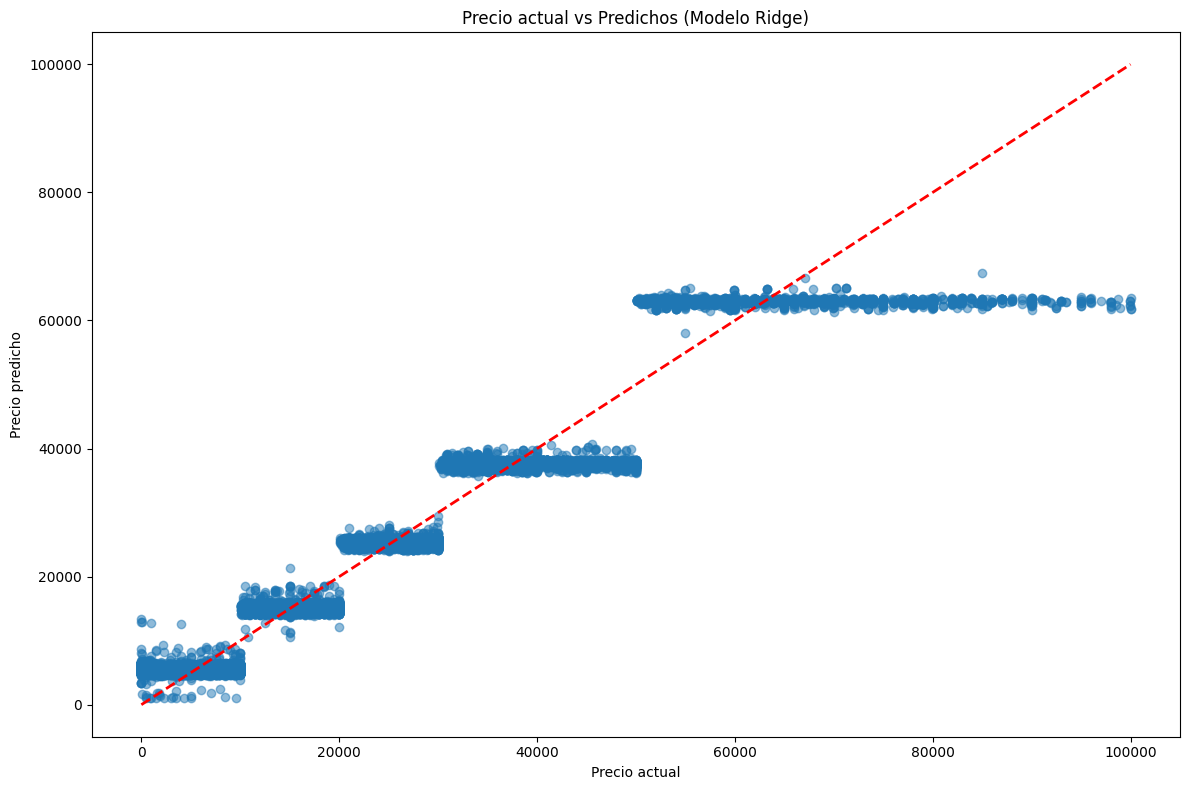

In [44]:
# Train Ridge model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio actual')
plt.ylabel('Precio predicho')
plt.title('Precio actual vs Predichos (Modelo Ridge)')
plt.tight_layout()
plt.savefig('precios predichos vs actuales.png')
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Conocimiento de los elementos principales que impactan en los precios de los vehículos de segunda mano:

- Se consiguio descifrar los elementos clave que impactan en el precio de los vehículos de segunda mano! Esta revelación ofrece un conocimiento fundamental a la agencia automotriz, permitiendo comprender qué atributos son cruciales al evaluar el valor de un auto.




- El rendimiento del modelo es bastante sólido; obtiene un R-cuadrado de 0.9321 que significa que explica el 93.21 % de la variabilidad en los precios de una manera aceptable y el RMSE de $3785.57 parece razonable teniendo en cuenta el rango de precios de los vehículos.




- El modelo suele ser preciso en general; sin embargo tiende un poco a subestimar los automóviles más costosos; esta es un aspect una posible de mejora.


Se ha creado un modelo que se ajusta de manera efectiva a los objetivos comerciales al ofrecer información relevante sobre los elementos que impactan en los precios de los vehículos de segunda mano.
   
   1. El rendimiento general del modelo es sólido y destaca por su precisión en la predicción de precios.
   Hemos descubierto las particularidades clave que afectan el valor monetario del producto y pueden resultar útiles para la empresa automotriz al establecer su política de precios.


   2. El modelo parece no valorar lo suficiente los vehículos más caros, algo que debería considerarse en las próximas actualización del modelo.
   Podemos investigar en mayor profundidad las relaciones entre variables para entender mejor conexiones más complejas.


   3. La agencia de automóviles cuenta ahora with una herramientra de confianza para calcular los precios de los vehículos de segunda mano.
   Los conocimientos sobre los elementos que afectan al costo pueden orientarnos en las elecciones de adquisición y venta y en la fijación de precios.
   El modelo puede ser útil para descubrir oportunidades en el mercado tales como vehículos que están siendo subvalorados o sobrevalorados.


   4. Falta mejorar el modelo para que las predicciones sean más precisas en los precios más elevados. Sería útil tener en cuenta agregar información más detallada sobre el mercado local si existen datos disponibles.
   Después de crear una interfaz amigable para que los empleados de la agencia automotriz puedan integrarlo en sus actividades cotidianas.
   Es importante programar actualizaciones periódicas del modelo con información reciente para garantizar su eficacia a lo largo del tiempo.


   5. La preparación de los datos y la elaboración de las características resultaron útiles; sin embargo, podríamos considerar investigar características extra que puedan reflejar de manera más precisa el valor de los vehículos de costo más elevado.
   Podemos explorar métodos de modelado más sofisticados o estrategias de combinación para seguir mejorando la precisión.

En resumen, se logro con las herramientas dadas hasta ahora y de forma satisfactoria los objetivos clave del proyecto al proporcionar una herramienta utilizable y valiosa para la estrategia de precios de la agencia de automóviles. El modelo actual es estable y só con algunas mejoras adicionales, especialmente en el tratamiento de vehículos de mayor valor, podrá transformarse en un instrument de toma de decisiones aún más eficiente en el sector de autos de segunda mano.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

# Informe de Predicción de Precios de Autos Usados

Este informe presenta los hallazgos de nuestro análisis de precios de autos usados. Nuestro objetivo fue comprender los factores clave que influyen en los precios de los autos usados y proporcionar información para ayudar a afinar la gestión del inventario para los concesionarios de autos usados.

## Hallazgos Clave

1. Los factores más influyentes en los precios de los autos usados son la categoría de precio, el año del vehículo, la edad, el kilometraje y el precio por milla.
2. El modelo alcanzó un puntaje R-cuadrado de 0.9321, lo que indica un alto nivel de precisión en la predicción de precios.
3. Hay una ligera tendencia a subestimar los vehículos de mayor precio, lo cual debe considerarse en las estrategias de precios.

## Visualizaciones

Las siguientes visualizaciones respaldan nuestros hallazgos:


### Caracteristicas importantes para predecir el precio del auto:

<center>
    <img src = images/lasso_feature_importances.png width = 50%/>
</center>

### Precios Reales vs Predichos (Modelo Ridge)
<center>
    <img src = images/actual_vs_predicted_prices.png width = 50%/>
</center>

### Residuos vs Precios Predichos (Modelo Ridge)
<center>
    <img src = images/residuals_plot.png width = 50%/>
</center>

### Distribución de Residuos (Modelo Ridge)
<center>
    <img src = images/residuals_distribution.png width = 50%/>
</center>

## Resumen del Rendimiento del Modelo

El modelo proporciona una herramienta confiable para predecir los precios de autos usados, con un error cuadrático medio de $3,785.57. Este nivel de precisión es adecuado para aplicaciones prácticas en la gestión de inventario.

## Implicaciones para la Gestión de Inventario

Los concesionarios pueden usar el modelo para establecer precios competitivos, identificar vehículos infravalorados o sobrevalorados y tomar decisiones de compra informadas. Los conocimientos sobre los factores que influyen en el precio también pueden guiar las estrategias de marketing y ventas.